# Modeling and Evaluation

Train and evaluate a series of KMeans models to find the best performing model by choosing a value for **k**.

## Steps:

1. **Load the Clean, Combined Dataset**
   - Load the preprocessed and combined dataset containing the audio features.

2. **Select Audio Features Based on Description**
   - Choose the relevant audio features from the dataset for clustering.

3. **Scale the Dataset**
   - Apply scaling (e.g., StandardScaler) to normalize the features before training the model.

4. **Train a Range of Models with Different k Values**
   - Train multiple KMeans models using different values for **k** (e.g., k=2, 3, 4, ..., 10).

5. **Evaluate and Select the Top 2 Values for k**
   - Use the **Elbow Method** to visually inspect the optimal number of clusters.
   - Use the **Silhouette Score** to evaluate how well-defined the clusters are.
   
6. **Try a Live Test with the Selected Models**
   - Test the two top-performing models (based on the Elbow Method and Silhouette Score) in a live setting.
   - Select the best performing value of **k** based on the test results.

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pickle
import os
import seaborn as sns
from sklearn.decomposition import PCA

In [9]:
df = pd.read_csv('../data/clean/spotify_data_encoded.csv')

In [10]:
def display_basic_info(df):
    """
    Display basic information about the dataset including shape, data types, and missing values
    """
    print('Dataset Shape:', df.shape)
    print('\nData Types:')
    print(df.dtypes)
    print('\nMissing Values:')
    print(df.isnull().sum())

def display_numerical_summary(df):
    """
    Display summary statistics for numerical columns
    """
    print('Numerical Columns Summary:')
    print(df.describe())

def check_duplicates(df):
    """
    Check for duplicate entries in the dataset
    """
    duplicates = df.duplicated().sum()
    print(f'Number of duplicate entries: {duplicates}')
    
def display_unique_values(df, columns):
    """
    Display number of unique values for specified columns, with special handling for the genres column
    """
    print('Unique Values Count:')
    for col in columns:
        if col == 'genres':
            all_genres = []
            for genre_list in df[col].dropna():
                if isinstance(genre_list, str):
                    genre_list = eval(genre_list)
                all_genres.extend(genre_list)
            unique_genres = len(set(all_genres))
            print(f'{col}: {unique_genres} unique genres')
        else:
            print(f'{col}: {df[col].nunique()} unique values')

In [11]:
display_basic_info(df)

check_duplicates(df)

display_unique_values(df, ['artist', 'release_year', 'genres'])

Dataset Shape: (7282, 25)

Data Types:
title               object
artist              object
album               object
release_year         int64
popularity           int64
is_explicit           bool
duration_seconds     int64
rock                 int64
pop                  int64
blues                int64
metal                int64
hip-hop              int64
country              int64
punk                 int64
jazz                 int64
rap                  int64
reggae               int64
folk                 int64
soul                 int64
latin                int64
dance                int64
indie                int64
classical            int64
album_cover         object
genres              object
dtype: object

Missing Values:
title               0
artist              0
album               0
release_year        0
popularity          0
is_explicit         0
duration_seconds    0
rock                0
pop                 0
blues               0
metal               0
hip-hop      

In [12]:
data = df.copy()

#### Select Audio Features

In [13]:
# Select relevant audio features (music genres)
features = data[['rock', 'pop', 'blues', 'metal', 'hip-hop', 'country', 
                 'punk', 'jazz', 'rap', 'reggae', 'folk', 'soul', 'latin', 
                 'dance', 'indie', 'classical']]

#### Scale the features 

In [14]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [15]:
# save the scaler
with open('../models/genre_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# tTest loading the scaler
with open('../models/genre_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
    
# check if it works
test_scaled = loaded_scaler.transform(features.head(1))
print('Verification - scaled features shape:', test_scaled.shape)

Verification - scaled features shape: (1, 16)


#### Train Models with Different k Values

In [16]:
# relevant features (encoded genres)
features = df[[
    'rock', 'pop', 'blues', 'metal', 'hip-hop', 'country', 
    'punk', 'jazz', 'rap', 'reggae', 'folk', 'soul', 'latin', 
    'dance', 'indie', 'classical'
]]

# scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# train models with different k values
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
models = [KMeans(n_clusters=k, random_state=42) for k in k_values]

# inertias for elbow method
inertias = []

for model in models:
    model.fit(scaled_features)
    inertias.append(model.inertia_)
    print(f'Model trained with k={model.n_clusters}')

Model trained with k=2
Model trained with k=3
Model trained with k=4
Model trained with k=5
Model trained with k=6
Model trained with k=7
Model trained with k=8
Model trained with k=9
Model trained with k=10


#### Train Models and Collect Metrics

In [17]:
k_values = range(2, 147)
results = []

for k in k_values:
    # train model
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    
    # metrics
    inertia = model.inertia_
    silhouette = silhouette_score(scaled_features, model.labels_)
    
    results.append({
        'k': k,
        'inertia': inertia,
        'silhouette': silhouette
    })
    print(f'k={k}: inertia={inertia:.0f}, silhouette={silhouette:.3f}')

k=2: inertia=108904, silhouette=0.185
k=3: inertia=100837, silhouette=0.259
k=4: inertia=93408, silhouette=0.292
k=5: inertia=86399, silhouette=0.301
k=6: inertia=80421, silhouette=0.324
k=7: inertia=73895, silhouette=0.353
k=8: inertia=67106, silhouette=0.343
k=9: inertia=62124, silhouette=0.359
k=10: inertia=55828, silhouette=0.398
k=11: inertia=49226, silhouette=0.430
k=12: inertia=43890, silhouette=0.465
k=13: inertia=38773, silhouette=0.507
k=14: inertia=33199, silhouette=0.540
k=15: inertia=27024, silhouette=0.593
k=16: inertia=24032, silhouette=0.637
k=17: inertia=22514, silhouette=0.648
k=18: inertia=19304, silhouette=0.708
k=19: inertia=18532, silhouette=0.713
k=20: inertia=17951, silhouette=0.717
k=21: inertia=17383, silhouette=0.724
k=22: inertia=15866, silhouette=0.738
k=23: inertia=15415, silhouette=0.742
k=24: inertia=14838, silhouette=0.757
k=25: inertia=14129, silhouette=0.790
k=26: inertia=13736, silhouette=0.792
k=27: inertia=13231, silhouette=0.796
k=28: inertia=1285

#### Evaluate using Elbow Method and Silhouette Score

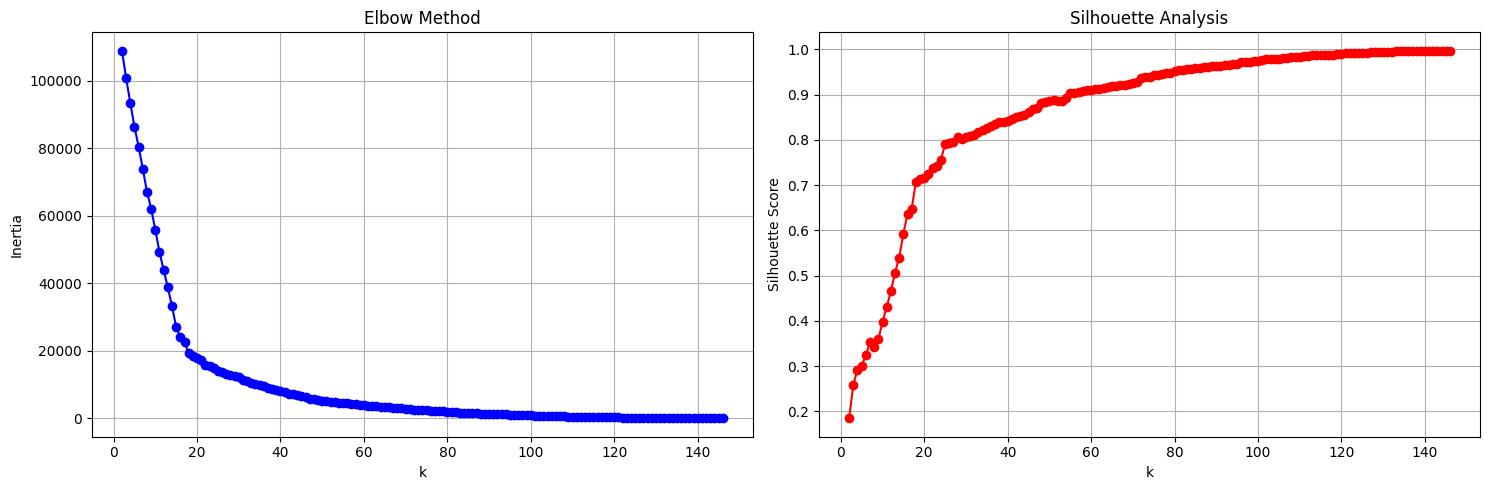


Top 2 k values based on silhouette score:
k=145: silhouette=0.997
k=146: silhouette=0.997


In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow Method Plot
inertias = [r['inertia'] for r in results]
ax1.plot(k_values, inertias, 'bo-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

# Silhouette Score Plot
silhouettes = [r['silhouette'] for r in results]
ax2.plot(k_values, silhouettes, 'ro-')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Find top 2 k values based on silhouette score
top_k_values = sorted(results, key=lambda x: x['silhouette'], reverse=True)[:2]
print('\nTop 2 k values based on silhouette score:')
for result in top_k_values:
    print(f"k={result['k']}: silhouette={result['silhouette']:.3f}")

####  Train Final Models with Top k Values

In [20]:
final_models = {}
for result in top_k_values:
    k = result['k']
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    final_models[k] = model
    
    #cluster sizes
    unique, counts = np.unique(model.labels_, return_counts=True)
    print(f'\nCluster sizes for k={k}:')
    for cluster, size in zip(unique, counts):
        print(f'Cluster {cluster}: {size} songs')
    
    # most common genres per cluster
    cluster_centers = pd.DataFrame(
        model.cluster_centers_,
        columns=features.columns
    )
    
    print(f'\nDominant genres in each cluster (k={k}):')
    for i in range(k):
        top_genres = cluster_centers.iloc[i].nlargest(3)
        print(f"Cluster {i}: {', '.join([f'{g} ({v:.2f})' for g, v in top_genres.items()])}")


Cluster sizes for k=145:
Cluster 0: 227 songs
Cluster 1: 554 songs
Cluster 2: 2042 songs
Cluster 3: 73 songs
Cluster 4: 109 songs
Cluster 5: 142 songs
Cluster 6: 116 songs
Cluster 7: 64 songs
Cluster 8: 131 songs
Cluster 9: 491 songs
Cluster 10: 94 songs
Cluster 11: 200 songs
Cluster 12: 107 songs
Cluster 13: 87 songs
Cluster 14: 35 songs
Cluster 15: 131 songs
Cluster 16: 173 songs
Cluster 17: 156 songs
Cluster 18: 22 songs
Cluster 19: 95 songs
Cluster 20: 68 songs
Cluster 21: 33 songs
Cluster 22: 199 songs
Cluster 23: 37 songs
Cluster 24: 50 songs
Cluster 25: 215 songs
Cluster 26: 114 songs
Cluster 27: 84 songs
Cluster 28: 7 songs
Cluster 29: 5 songs
Cluster 30: 5 songs
Cluster 31: 28 songs
Cluster 32: 13 songs
Cluster 33: 54 songs
Cluster 34: 19 songs
Cluster 35: 50 songs
Cluster 36: 8 songs
Cluster 37: 124 songs
Cluster 38: 26 songs
Cluster 39: 74 songs
Cluster 40: 16 songs
Cluster 41: 14 songs
Cluster 42: 107 songs
Cluster 43: 55 songs
Cluster 44: 7 songs
Cluster 45: 13 songs
Clus

### Evaluate the models


Clustering Evaluation Metrics:
Silhouette Score: 0.911
Inertia: 4051


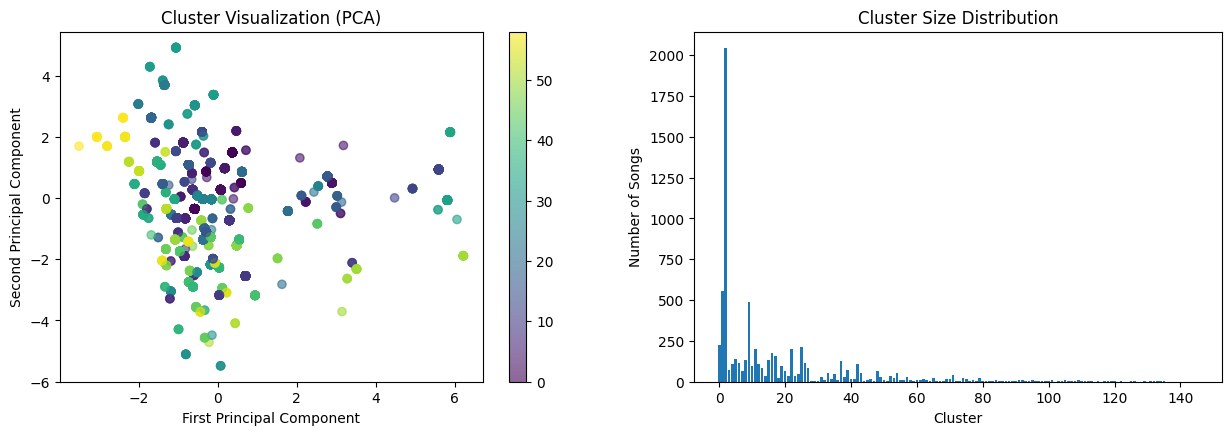

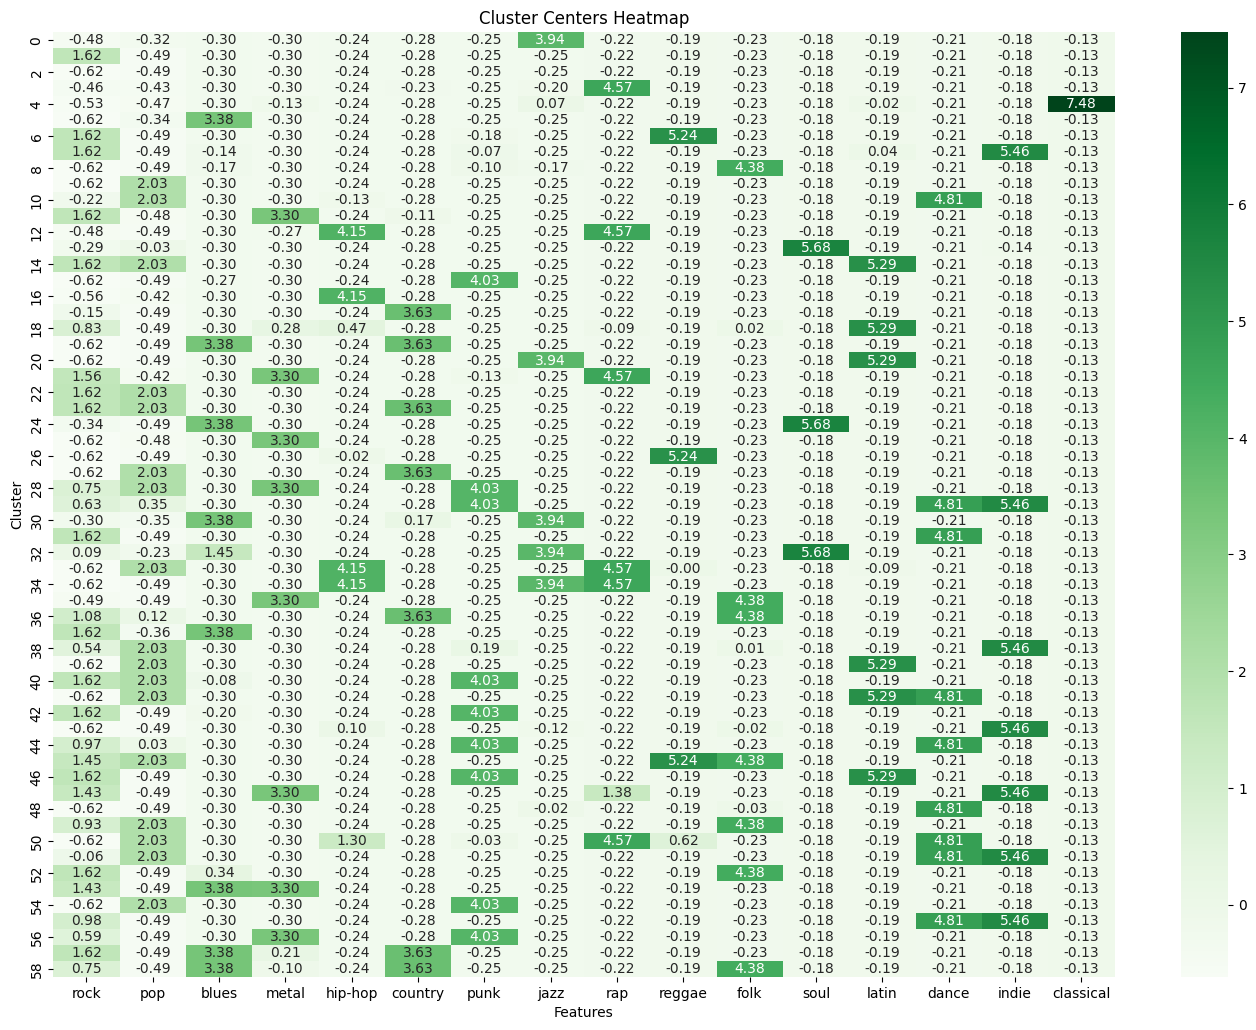

In [21]:
def evaluate_clustering(scaled_features, model, feature_names):
    """
    Evaluate clustering results using multiple metrics and visualizations
    """
    labels = model.labels_
    centers = model.cluster_centers_
    
    # basic metrics
    silhouette = silhouette_score(scaled_features, labels)
    inertia = model.inertia_
    
    print(f'\nClustering Evaluation Metrics:')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Inertia: {inertia:.0f}')
    
    # cluster sizes
    # unique, counts = np.unique(labels, return_counts=True)
    # print('\nCluster Sizes:')
    # for cluster, size in zip(unique, counts):
    #     print(f'Cluster {cluster}: {size} songs ({size/len(labels)*100:.1f}%)')
    
    # analyze cluster characteristics
    cluster_centers = pd.DataFrame(
        centers,
        columns=feature_names
    )
    
    # print('\nDominant Genres per Cluster:')
    # for i in range(len(centers)):
    #     top_genres = cluster_centers.iloc[i].nlargest(3)
    #     print(f"Cluster {i}: {', '.join([f'{g} ({v:.2f})' for g, v in top_genres.items()])}")
    
    # visualizations
    plt.figure(figsize=(15, 10))
    
    # PCA visualization of clusters
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(scaled_features)
    
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], 
                         c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    
    plt.subplot(2, 2, 2)
    plt.bar(unique, counts)
    plt.title('Cluster Size Distribution')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Songs')
    
    plt.figure(figsize=(14, 20))
    plt.subplot(2, 2, (3, 4))
    sns.heatmap(cluster_centers, annot=True, cmap='Greens', fmt='.2f')
    plt.title('Cluster Centers Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Cluster')
    
    plt.tight_layout()
    plt.show()
    
    return silhouette, inertia

best_k = 59
best_model = KMeans(n_clusters=best_k, random_state=42)
best_model.fit(scaled_features)

# evaluate the model
silhouette, inertia = evaluate_clustering(
    scaled_features, 
    best_model, 
    features.columns
)

# save best model
with open('../models/kmeans_genre_classifier.pkl', 'wb') as f:
    pickle.dump(best_model, f)

#### Select best performer (k-means) and label data

In [22]:
# Iterate over different values of k (number of clusters)
k = result['k']  # number of clusters from `result`

# Create the KMeans model with the selected number of clusters
model = KMeans(n_clusters=k, random_state=42)

# Fit the model to the scaled features
model.fit(scaled_features)

# Store the model in a dictionary, keyed by the number of clusters
final_models[k] = model

# Optionally, you can add the cluster labels to the DataFrame
df['cluster'] = model.labels_

# Save the dataset with the cluster labels
# df.to_csv('7_clustered_dataset.csv', index=False)